## This is my attempt to use martin's data creation technique and then put it in Siamene Network using Fast AI. I am using following links for this:
https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb

In [1]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

import random
from scipy.ndimage import affine_transform

import pickle
import numpy as np
from math import sqrt

# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

from pandas import read_csv
import pandas as pd

In [2]:
df = pd.read_csv('data/whale/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')

For training data, we are taking all the images except for the category - New Whale

In [3]:
new_df = df[df['Id']!= 'new_whale']
#new_df = new_df[new_df['sighting_count']>1]

print('shape of data for training ',new_df.shape)
new_df.drop(columns = ['sighting_count'] , inplace=True)
new_df.head(2)

shape of data for training  (15697, 3)


/home/FRACTAL/jitesh.arora/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


In [4]:
new_df.reset_index(inplace=True)
new_df.drop(columns='index' , inplace=True)
new_df.tail(3)

,Image,Id
15694,fff7faf61.jpg,w_9cf0388
15695,fff9002e0.jpg,w_bd1c3d5
15696,fffcde6fe.jpg,w_9f30885


In [5]:
"""
The data set we are using for training contains all images except of new whales.
we don't require creating phase values for this  datasets , as duplicate images are very few.
i am using index present in train.csv as the phase value as we can use it for indexing very easily 
"""

tagged = dict([(p,w) for _,p,w in new_df.to_records()])
h2ps = dict([(idx , p ) for   idx,p,w in new_df.to_records()])
p2h   = dict([(p , idx) for idx , p , w in new_df.to_records()])
h2p = h2ps.copy()
join = tagged.copy()

In [6]:
def expand_path(p):
    if isfile('data/whale/train-224/' + p): return 'data/whale/train-224/' + p
    if isfile('data/whale/test-224/' + p): return 'data/whale/test-224/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

(15697,
 [('0000e88ab.jpg', (224, 224)),
  ('0001f9222.jpg', (224, 224)),
  ('00029d126.jpg', (224, 224)),
  ('000a6daec.jpg', (224, 224)),
  ('0016b897a.jpg', (224, 224))])

In [7]:
## phase value for all categories except new whale
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

15697

In [8]:
## for each whale category, observe the associated phase values , 
##store all whale categories even the categories with just one image ( this is  different from martin's approach)

w2hs = {}
for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous pictures

        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
for w,hs in w2hs.items():
    #if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)

5004

In [9]:
len(h2ws)

15697

In [10]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img


import matplotlib.pyplot as plt


In [11]:
train = [] # A list of  indices of images to be used in training data.
for hs in w2hs.values():
    if len(hs) >= 1:
        train += hs
random.shuffle(train)
train_set = set(train)

In [12]:
## we have whales categories with phases(images) more than 1. shuffle the phase values now.
w2ts = {} #Associate the image index from train to each whale id.
for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
## then again for each whale categories see how many images you have , 
## you are working with 5004 whale categories and 15697 images 
    
    
t2i = {} # The position in train of each training image id
for i,t in enumerate(train): t2i[t] = i

len(train),len(w2ts)

(15697, 5004)

In [14]:
# from keras.utils import Sequence
# import keras

from IPython.core.debugger import set_trace
import random
#from keras import backend as K

try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment


Import functions from fast ai library

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

from IPython.core.debugger import set_trace
from functional import seq


In [19]:
name = f'resnet18_martin_data'

fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}  #new_
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)


SZ = 224
BS = 64//4
NUM_WORKERS = 12
SEED=0

Creating dataset for all the training images. Because of some reason , i am not able to create validation set as well ( produces error while indexing from match and unmatch matrices. If someone is able to find the work arounf the help will be appreciated

In [20]:
classes = df.Id.unique()
data = (
    ImageItemList  ##df[(df.Id != 'new_whale') & (df.sighting_count >1)]
        .from_df( df[(df.Id != 'new_whale')], f'data/whale/train-{SZ}', cols=['Image'])
        .no_split()##split_by_valid_func(lambda path: path2fn(path) in val_fns) 
        .label_from_func(lambda path: fn2label[path2fn(path)] ,  classes=classes)
        .add_test(ImageItemList.from_folder(f'data/whale/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH))

In [21]:
print(len(train))
print(len(data.train.x))
print(len(data.valid.x))

15697
15697
1


In [22]:
from IPython.core.debugger import set_trace
import random

# First try to use lapjv Linear Assignment Problem solver as it is much faster.
# At the time I am writing this, kaggle kernel with custom package fail to commit.
# scipy can be used as a fallback, but it is too slow to run this kernel under the time limit
# As a workaround, use scipy with data partitioning.
# Because algorithm is O(n^3), small partitions are much faster, but not what produced the submitted solution
try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment


TwoImDataset creation is the part where I am trying to replicate 'TrainingData Class' from https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
For whale categories having just one images in training data , matching pair -  same image pair (A,A) . For other categories it creates a de arrangement.  

In [23]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds ,score  , steps = 1000):
        self.ds = ds
        self.whale_ids = ds.y.items
        self.steps =1000
        self.score  = -score
        for ts in w2ts.values():
            idxs =  ts.copy() #[t2i[t] for t in ts]
            #idxs = [i for i in  idxs if i <score.shape[0]]
            for i in idxs:
                for j in idxs:
                    self.score[i,j] = 10000.0   # Set a large value for matching
        
        self.on_epoch_end()
        
    def __len__(self):
        return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_image(idx // 2 , 1)
        else: return self.sample_image((idx-1) // 2 ,0)        

    def sample_image(self, idx , tag):
        #set_trace()
        if tag==0:
            first_image_id =  self.match[idx][0]
            second_image_id = self.match[idx][1]
            #if first_image_id < len(self.ds) and second_image_id< len(self.ds):         
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 1)
        else:
            first_image_id =  self.unmatch[idx][0]
            second_image_id = self.unmatch[idx][1]     
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 0)
  
    def on_epoch_end(self):
        if self.steps <= 0: return # Skip this on the last epoch.
        self.steps     -= 1
        self.match      = []
        self.unmatch    = []
        if segment:
            tmp   = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _,_,x = lapjv(self.score) # Solve the linear assignment problem
        y = np.arange(len(x),dtype=np.int32)

        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            if (len(d)==1):
                for ab in zip(ts,d): self.match.append(ab)
            else:                
                while True:
                    random.shuffle(d)
                    if not np.any(ts == d): break
                for ab in zip(ts,d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i,j in zip(x,y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i,j)
            assert i != j
            self.unmatch.append((train[i],train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x,y] = 10000.0
        self.score[y,x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        print('end of epoch',self.match[0][0])
        print('end of epoch',self.unmatch[0][0])
        
        print(len(self.match), len(train), len(self.unmatch), len(train))
        #assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [24]:
"""
Create a 2D score matrix of size of training data
"""

score = np.random.random_sample(size=(len(train),len(train)))

train_dl = DataLoader(
    TwoImDataset(data.train , score),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)


end of epoch 13301
end of epoch 2316
15697 15697 15697 15697


In [25]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [26]:
data_bunch = ImageDataBunch(train_dl , train_dl) ##, valid_dl
data_bunch.add_tfm(normalize_batch)

In [27]:
"""
The netowrk architecture is also inspired from Martin's notebook (part after we extract features for two image pairs)
"""
class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        
        self.cnn = create_body(arch)
        self.head = nn.Linear(num_features_model(self.cnn), 1)  #
        
        self.conv1 = nn.Conv2d(1 , 32 , kernel_size= (1 , 4) , padding = 0 ,stride=1)
        self.conv2 = nn.Conv2d( 1 , 1 , kernel_size = (32 ,1 ) , padding = 0  , stride=1)

    def forward(self, im_A, im_B):
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)
        d1 = self.calculate_distance(x1, x2)
        d2 = (x1 + x2)
        d3 = (x1*x2)
        d4 = (x1-x2)*(x1 - x2)
        concat_layer = torch.cat([d1 ,d2,d3, d4]  ,dim = 1)
        concat_layer = concat_layer.view( - 1, 1, num_features_model(self.cnn) , 4)   ## no of channels is second dimension
        concat_layer  = F.relu(self.conv1(concat_layer))
        concat_layer = concat_layer.view(-1 ,1,32, num_features_model(self.cnn)  )
        concat_layer = F.relu(self.conv2(concat_layer))
        concat_layer_fn = concat_layer.view(-1 ,num_features_model(self.cnn) )
        out = self.head(concat_layer_fn)
        return out
    
    def process_features(self, x): 
        y = x.reshape(*x.shape[:2], -1)
        return x.reshape(*x.shape[:2], -1).max(-1)[0]
    def calculate_distance(self, x1, x2): return (x1 - x2).abs_()

In [28]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [29]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


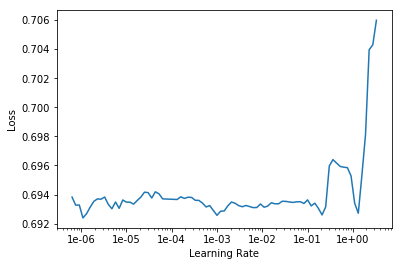

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(4 , 1e-3)

epoch,train_loss,valid_loss,
1,0.388826,0.401715,0.791776
2,0.310544,0.298000,0.862076
3,0.265223,0.263870,0.864305
4,0.235134,0.237953,0.892177


In [48]:
learn.unfreeze()

In [49]:
max_lr = 5e-4
lrs = [max_lr/100, max_lr/10, max_lr]

In [50]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,
1,0.199618,0.226004,0.892973
2,0.221874,0.229621,0.882048
3,0.232100,0.221465,0.887208
4,0.205440,0.163407,0.932185
5,0.171731,0.138759,0.942664
6,0.141226,0.106391,0.956202
7,0.095533,0.072366,0.972606
8,0.062427,0.053985,0.981525
9,0.053467,0.044704,0.984679
10,0.038683,0.042204,0.985475


In [51]:
learn.save(f'{name}-stage2_unfz')

In [52]:
learn.load(f'{name}-stage2_unfz');

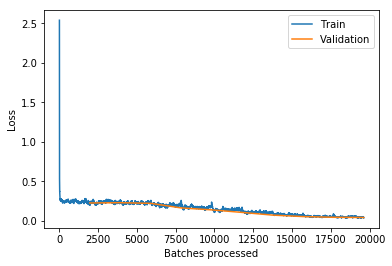

In [53]:
learn.recorder.plot_losses()

In [54]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,
1,0.048071,0.046917,0.981780
2,0.085961,0.116492,0.940753
3,0.134944,0.104413,0.961872
4,0.110086,0.108361,0.945117
5,0.110862,0.073613,0.968019
6,0.076461,0.046970,0.980729
7,0.034342,0.032400,0.984965
8,0.019661,0.018537,0.992960
9,0.014298,0.012686,0.995604
10,0.012486,0.013554,0.995764


In [55]:
learn.save(f'{name}-stage3_unfz')

In [30]:
learn.load(f'{name}-stage3_unfz');

In [55]:
new_whale_fns = set(df[df['Id']=='new_whale'].sample(frac = 1).Image.iloc[:1000])
#new_whale_fns

In [56]:
val_fns = set(df[df.sighting_count == 2].Image)
print(len(val_fns) + len(new_whale_fns))

classes = df.Id.unique()

df = df.drop(columns = ['sighting_count'])
df.head(2)

AttributeError: 'DataFrame' object has no attribute 'sighting_count'

In [73]:

data = (
    ImageItemList
        .from_df(df, f'data/whale/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns) ##.union(new_whale_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/whale/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [74]:
%%time
targs = []
feats = []
learn.model.eval()
for ims, ts in data.valid_dl:
    feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())  ##
    targs.append(ts)

feats = torch.cat(feats)
print(feats.shape)

torch.Size([2570, 512])
CPU times: user 3.48 s, sys: 1.82 s, total: 5.3 s
Wall time: 5.61 s


In [77]:
%%time
sims = []
for feat in feats:
    x1 = feats#.copy()
    x2 = feat.unsqueeze(0).repeat(2570 ,1)
    d1 = learn.model.calculate_distance(x1 , x2)
    d2 = (x1 + x2)
    d3 = (x1*x2)
    d4 = (x1-x2)*(x1 - x2)
    concat_layer = torch.cat([d1 ,d2,d3, d4]  ,dim = 1)
    concat_layer = concat_layer.view( - 1, 1, num_features_model(learn.model.cnn) , 4)   ## no of channels is second dimension
    concat_layer  = F.relu(learn.model.conv1(concat_layer.cuda()))
    concat_layer = concat_layer.view(-1 ,1,32, num_features_model(learn.model.cnn)  )
    concat_layer = F.relu(learn.model.conv2(concat_layer))
    concat_layer_fn = concat_layer.view(-1 ,num_features_model(learn.model.cnn) )
    #out = learn.model.head(concat_layer_fn)
    predicted_similarity = learn.model.head(concat_layer_fn).sigmoid_()  #.cuda()
    sims.append(predicted_similarity.squeeze().detach().cpu())

    


CPU times: user 1min 17s, sys: 3.25 s, total: 1min 20s
Wall time: 1min 20s


In [78]:
len(sims[0])

2570

In [79]:
new_whale_idx = np.where(classes == 'new_whale')[0][0]
new_whale_idx

3

In [80]:
%%time
top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if len(top_5) == 5: break
        if j == i: continue   
        predicted_class = data.valid_ds.y.items[j]
        """
        we dont want to predict new whale for validation data 
        """
        if predicted_class == new_whale_idx: continue
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)
    
## top 5 contains 5 best predicted classes ,w ith indices from classes dictionary

CPU times: user 852 ms, sys: 0 ns, total: 852 ms
Wall time: 850 ms


In [81]:
top_5s[:5]

[[6, 4753, 2555, 3146, 1911],
 [3030, 2072, 4294, 2673, 3043],
 [1982, 3065, 177, 14, 3405],
 [15, 3157, 1530, 3572, 4087],
 [2890, 24, 1791, 3167, 2447]]

In [82]:
"""
mapk of validation data set without having new whales in predictions. 
"""
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

0.5175356679636836

In [72]:
# %%time
"""
trying to calcualte threshold probability for new whale, which maximises the mapk for validation data.
"""

for thresh in np.linspace(0.7, 1, 12):
    top_5s = []
    for i, sim in enumerate(sims):
        idxs = sim.argsort(descending=True)
        probs = sim[idxs]
        top_5 = []
        for j, p in zip(idxs, probs):
            if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
            if len(top_5) == 5: break
            if j == i: continue
            predicted_class = data.valid_ds.y.items[j]
            if predicted_class not in top_5: top_5.append(predicted_class)
        top_5s.append(top_5)
    print(thresh, mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5))

0.7 0.49298786181139126
0.7272727272727272 0.49298786181139126
0.7545454545454545 0.49298786181139126
0.7818181818181817 0.49298786181139126
0.8090909090909091 0.49298786181139126
0.8363636363636363 0.49298786181139126
0.8636363636363636 0.49298786181139126
0.8909090909090909 0.49298786181139126
0.9181818181818182 0.49298786181139126
0.9454545454545454 0.49298786181139126
0.9727272727272727 0.49298786181139126
1.0 0.4986881419234361


In [83]:
data = (
    ImageItemList
        .from_df(df, f'data/whale/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in {'69823499d.jpg'}) # in newer version of the fastai library there is .no_split that could be used here
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/whale/test-{SZ}'))
        .transform(None, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [84]:
%%time
test_feats = []
learn.model.eval()
for ims, _ in data.test_dl:
    test_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    
    
test_feats = torch.cat(test_feats)


CPU times: user 9.64 s, sys: 3.56 s, total: 13.2 s
Wall time: 13.7 s


In [85]:
%%time
train_feats = []
train_class_idxs = []
learn.model.eval()
for ims, t in data.train_dl:
    train_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    train_class_idxs.append(t)
    
train_class_idxs = torch.cat(train_class_idxs)
train_feats = torch.cat(train_feats)

CPU times: user 31 s, sys: 8.31 s, total: 39.3 s
Wall time: 40.4 s


In [86]:
len(train_class_idxs)
len(train_feats)

25360

In [87]:
%%time
sims = []
for feat in test_feats:
    dists = learn.model.calculate_distance(train_feats, feat.unsqueeze(0).repeat(25360, 1))
    
    x1 = train_feats
    x2 = feat.unsqueeze(0).repeat(25360 ,1)
    d1 = learn.model.calculate_distance(x1 , x2)
    d2 = (x1 + x2)
    d3 = (x1*x2)
    d4 = (x1-x2)*(x1 - x2)
    concat_layer = torch.cat([d1 ,d2,d3, d4]  ,dim = 1)
    concat_layer = concat_layer.view( - 1, 1, num_features_model(learn.model.cnn) , 4)   ## no of channels is second dimension
    concat_layer  = F.relu(learn.model.conv1(concat_layer.cuda()))
    concat_layer = concat_layer.view(-1 ,1,32, num_features_model(learn.model.cnn)  )
    concat_layer = F.relu(learn.model.conv2(concat_layer))
    concat_layer_fn = concat_layer.view(-1 ,num_features_model(learn.model.cnn) )
    predicted_similarity = learn.model.head(concat_layer_fn).sigmoid_()  #.cuda()
    sims.append(predicted_similarity.squeeze().detach().cpu())

    


CPU times: user 35min 38s, sys: 27min 52s, total: 1h 3min 30s
Wall time: 1h 3min 33s


In [99]:
%%time
thresh = 1#0.95

top_5s = []

for sim in sims:
    idxs = sim.argsort(descending = True)
    probs = sim[idxs]
    top_5 = []
    
    
    for  i , p in zip(idxs , probs):
        if new_whale_idx not in top_5 and p < thresh  and len(top_5) < 5:
            top_5.append(new_whale_idx)
        if len(top_5) ==5: break
        #if i == new_whale_idx: continue
        predicted_class = train_class_idxs[i]
        #print(predicted_class)
        if predicted_class == new_whale_idx: continue
        if predicted_class not in top_5:
            top_5.append(predicted_class)
    top_5s.append(top_5)
    

CPU times: user 26.8 s, sys: 292 ms, total: 27.1 s
Wall time: 27.4 s


In [100]:
top_5_classes  = []

for top_5 in top_5s:
    top_5_classes.append(' '.join([classes[t] for t in top_5]))

In [101]:
top_5_classes[:5]

['w_27597ff new_whale w_0e4b65e w_2c0f96c w_73b2fe3',
 'new_whale w_114a297 w_6cda039 w_c1efffb w_5010896',
 'new_whale w_3982e1e w_51e7506 w_d9d1e17 w_cd4cb49',
 'new_whale w_d066c0a w_72288ee w_c8bbb43 w_ac2c28e',
 'new_whale w_ae393cd w_bb2c919 w_da011a1 w_61b9586']

In [102]:
sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
sub['Id'] = top_5_classes
name2 = 'martin_siamene_network_15k_training_images'
sub.to_csv(f'data/whale/subs/{name2}.csv', index=False) 



In [103]:
pd.read_csv(f'data/whale/subs/{name2}.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.7523869346733668

In [104]:
#name = 'Ensembleing_resnet50_renet101_siamene_v1'
! kaggle competitions submit -c humpback-whale-identification -f data/whale/subs/{name}.csv -m "resnet18 arch prob 1 for new whales"

100%|████████████████████████████████████████| 498k/498k [00:06<00:00, 74.4kB/s]
Successfully submitted to Humpback Whale Identification